##### DATA ANALYSIS TEXTBOOK
##### Chapter 14 log vs level
#
##### Used car data for LA and Chicago

NOTE: Linear regression evaluation and crossvalidation table not correct, 80%PI table is missing


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch14-used-cars-log/"
output = dirname + "da_case_studies/ch14-used-cars-log/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")

In [5]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [6]:
# drop hybrid models then drop column
data = (data.query("Hybrid==0")).drop(["Hybrid"], axis=1)

# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
data = data.query("price in @seq(500,25001,by=1)").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("~(type=='truck')")

# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [7]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3

In [8]:
# focus only on Chicago
data = data.query("area=='chicago'")

### Compare Graphs
#### lowess:price

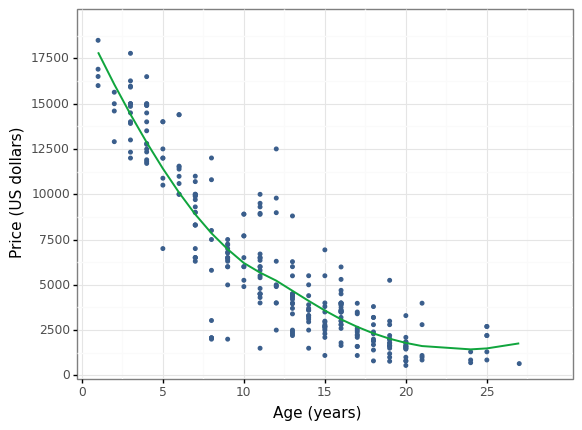

<ggplot: (284225142)>

In [9]:
ggplot(data, aes(x="age", y="price")) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(
    method="loess", color=color[1], se=False, size=0.8, na_rm=True
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, 2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5)
) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw()


#### lowess: lnprice

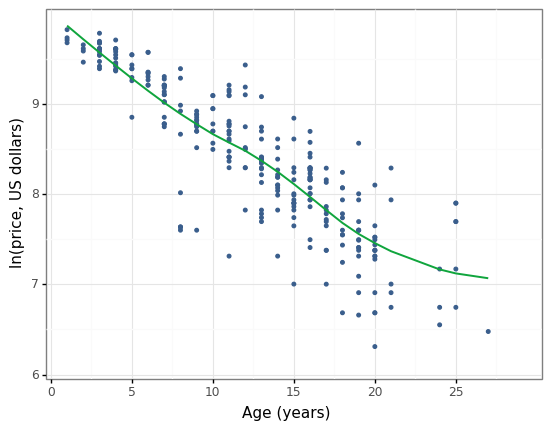

<ggplot: (329880573)>

In [10]:
ggplot(data, aes(x="age", y="lnprice")) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(
    method="loess", color=color[1], se=False, size=0.8, na_rm=True
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(6, 10), breaks=seq(6, 10, 1)
) + labs(
    x="Age (years)", y="ln(price, US dollars)"
) + theme_bw()


---
### Linear regressions

In [11]:
# Model 1: Linear regression on age
reg1=smf.ols("lnprice~age",data=data).fit(cov_type="HC0")
reg2=smf.ols("lnprice~age+odometer",data=data).fit(cov_type="HC0")
reg3=smf.ols("lnprice ~ age  + odometer +  LE + cond_excellent + cond_good + dealer",data=data).fit(cov_type="HC0")
reg4=smf.ols("lnprice ~ age  + odometer +  LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",data=data).fit(cov_type="HC0")
reg5=smf.ols("lnprice ~ age +  odometer + LE*age + XLE*age + SE*age + cond_likenew*age + cond_excellent*age + cond_good*age + cylind6*age + odometer*age + dealer*age",data=data).fit(cov_type="HC0")

In [12]:
from sklearn.metrics import mean_squared_error
models = [reg1, reg2,reg3, reg4, reg5]
AIC=[None]*len(models)
BIC=[None]*len(models)
RMSE=[None]*len(models)
Rsquared=[None]*len(models)
regr=[None]*len(models)
k=[None]*len(models)

for i in range(0,len(models)):
    AIC[i]=models[i].aic
    BIC[i]=models[i].bic
    RMSE[i]=rmse(models[i].fittedvalues,data.lnprice) #note lnprice added manually
    Rsquared[i]=models[i].rsquared
    #regr[i]
    k[i]=(models[i].df_model)

In [14]:
# 
eval=pd.DataFrame({'models':['(' + str(x+1) + 'log)'for x in range(len(models))],'k':k,'RSquared':Rsquared,'RMSE':RMSE,'BIC':BIC}).set_index('models')
eval

,k,RSquared,RMSE,BIC
models,,,,
(1log),1.0,0.764902,0.393410,284.428514
(2log),2.0,0.815701,0.348323,221.659683
(3log),6.0,0.823499,0.340874,232.064170
(4log),10.0,0.831498,0.333061,241.585809
(5log),19.0,0.845032,0.319405,268.802680


### Cross validation
---

In [15]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [16]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=1)

In [17]:
cv1 = cv_reg("lnprice~age", data, k, "HC0")
cv2 = cv_reg("lnprice~age+odometer", data, k, "HC0")
cv3 = cv_reg(
    "lnprice~ age  + odometer +  LE + cond_excellent + cond_good + dealer",
    data,
    k,
    "HC0",
)
cv4 = cv_reg(
    "lnprice~ age  + odometer +  LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    data,
    k,
    "HC0",
)
cv5 = cv_reg(
    "lnprice~ age +  odometer + LE*age + XLE*age + SE*age + cond_likenew*age + cond_excellent*age + cond_good*age + cylind6*age + odometer*age + dealer*age",
    data,
    k,
    "HC0",
)
cv_list = [cv1, cv2, cv3, cv4, cv5]

In [18]:
## Note default summary stat is rmse, but you can choose rsquared as well
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4,Model5
Fold1,0.367006,0.335899,0.330731,0.319313,0.298710
Fold2,0.380280,0.320980,0.312855,0.300990,0.286505
Fold3,0.403072,0.360279,0.349162,0.342313,0.327054
Fold4,0.413217,0.364764,0.355472,0.346686,0.328250
Average,0.390894,0.345480,0.337055,0.327325,0.310130


### Prediction
---

In [19]:
new = pd.DataFrame(pd.Series({
    "age":10,
    "agesq":10**2,
    "odometer":12,
    "odometersq":12**2,
    "SE":0,
    "LE":1,
    "XLE":0,
    "cond_likenew":0,
    "cond_excellent":1,
    "cond_good":0,
    "dealer":0,
    "price":np.nan,
    "cylind6":0
})).T
new

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [20]:
#turning off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [21]:
## RMSE for reg3
rmse3=rmse(reg3.fittedvalues,data.lnprice)
rmse3

0.3408742697315515

In [22]:
predln_new=reg3.get_prediction(new).summary_frame()
predln_new80=reg3.get_prediction(new).summary_frame(alpha=0.2)
predln_new,predln_new80

(   mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
 0 8.641    0.057          8.531          8.752         7.956         9.327,
    mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
 0 8.641    0.057          8.569          8.714         8.193         9.090)

In [23]:
lnp2_new=predln_new['mean'][0]
lnp2_new

8.64134191237252

In [24]:
#prediction in levels
data['lnplev']=np.exp(reg3.fittedvalues)*np.exp(rmse3**2/2)
lnp2_new_lev=np.exp(lnp2_new)*np.exp(rmse3**2/2)
lnp2_new_lev

5999.548805234597

In [25]:
# prediction interval (log and level)
lnp2_PIlow=predln_new['obs_ci_lower'][0]
lnp2_PIhigh=predln_new['obs_ci_upper'][0]
lnplev_PIlow=np.exp(lnp2_PIlow)*np.exp(rmse3**2/2)
lnplev_PIhigh=np.exp(lnp2_PIhigh)*np.exp(rmse3**2/2)

In [26]:
# prediction interval (log and level) - 80%
lnp2_PIlow80=predln_new80['obs_ci_lower'][0]
lnp2_PIhigh80=predln_new80['obs_ci_upper'][0]
lnplev_PIlow80=np.exp(lnp2_PIlow80)*np.exp(rmse3**2/2)
lnplev_PIhigh80=np.exp(lnp2_PIhigh80)*np.exp(rmse3**2/2)

In [27]:
pd.DataFrame({" ":['Predicted','PI_low','PI_high'], "Model in logs":[lnp2_new,lnp2_PIlow,lnp2_PIhigh],"Recalculated to level":[lnp2_new_lev,lnplev_PIlow,lnplev_PIhigh]})

,,Model in logs,Recalculated to level
0,Predicted,8.641,5999.549
1,PI_low,7.956,3022.529
2,PI_high,9.327,11908.763


In [27]:
pd.DataFrame({" ":['Predicted','PI_low','PI_high'], "Model in logs":[lnp2_new,lnp2_PIlow80,lnp2_PIhigh80],"Recalculated to level":[lnp2_new_lev,lnplev_PIlow80,lnplev_PIhigh80]})

,,Model in logs,Recalculated to level
0,Predicted,8.641,5999.549
1,PI_low,8.193,3832.054
2,PI_high,9.090,9393.027
